# Basics of Customer Segmentation in Python

### In this tutorial we would implement customer segmentation using RFM(Recency, Frequency, Monetary, Consistency) analysis from scratch and introduction to Kmeans in Python.


## Dunnhumby Case Notebook

In [625]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

#### Reading all files

In [243]:
#Importing necessary packages

import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [244]:
cd /Users/adityakamboj/Desktop/Dunn/Dunn1

/Users/adityakamboj/Desktop/Dunn/Dunn1


In [245]:
# Union all the csv files

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

df=pd.concat([pd.read_csv(f) for f in all_filenames])

In [246]:
# Printing head of the dataframe

display(df.head())
display(len(df.index))

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,...,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
0,200714,20070529,3,18,1,1.56,PRD0900173,CL00045,DEP00011,G00004,...,UM,OT,994106000428564,L,UM,Top Up,Mixed,STORE00001,LS,E02
1,200714,20070530,4,19,1,0.50,PRD0900336,CL00006,DEP00002,G00001,...,MM,OA,994106000362841,M,LA,Small Shop,Grocery,STORE00001,LS,E02
2,200714,20070529,3,18,3,1.23,PRD0900407,CL00028,DEP00008,G00004,...,UM,OT,994106000428564,L,UM,Top Up,Mixed,STORE00001,LS,E02
3,200714,20070529,3,21,4,3.00,PRD0900447,CL00140,DEP00049,G00014,...,LA,OT,994106000288924,L,MM,Full Shop,Mixed,STORE00001,LS,E02
4,200714,20070529,3,18,3,2.82,PRD0900471,CL00152,DEP00052,G00015,...,UM,OT,994106000428564,L,UM,Top Up,Mixed,STORE00001,LS,E02


3158469

#### Checking for missing Vales

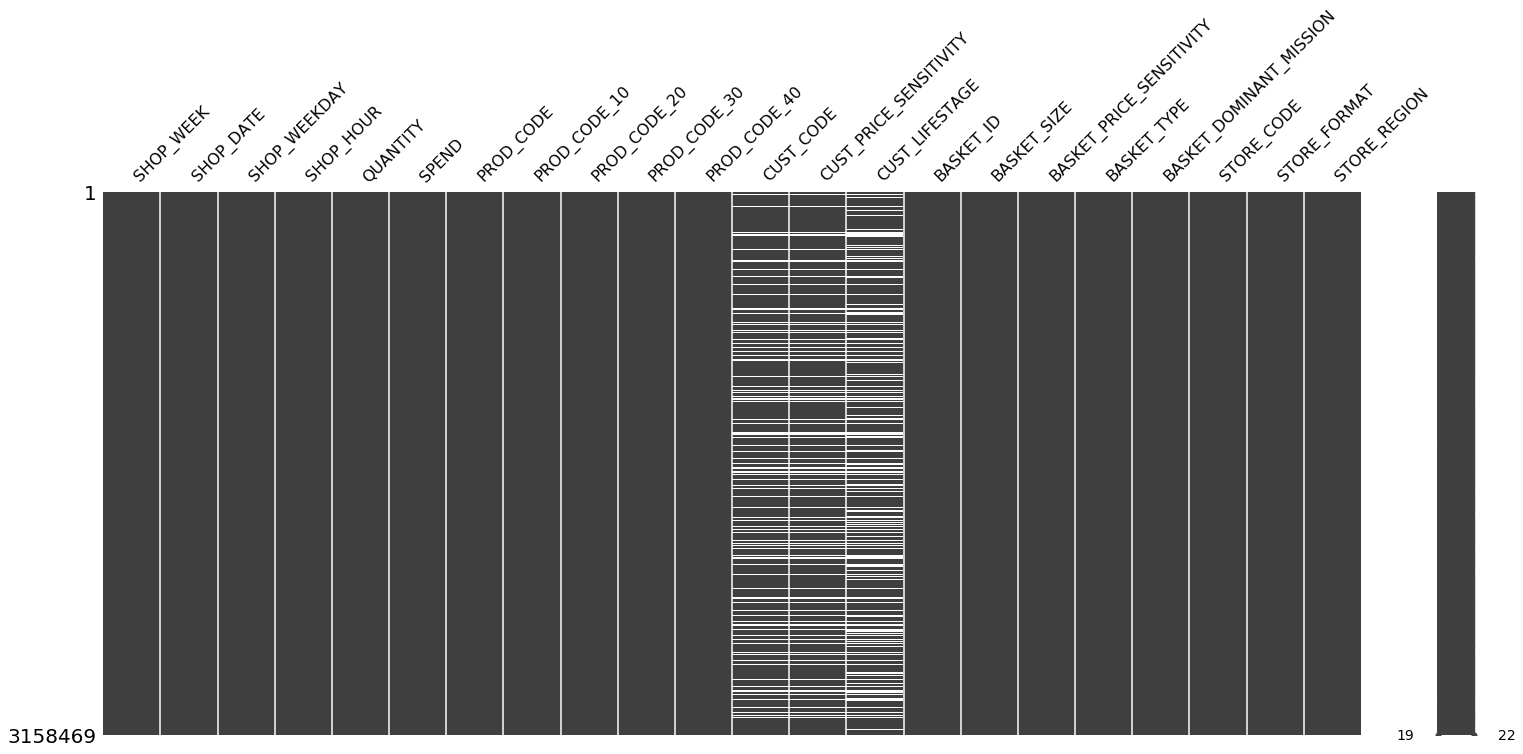

In [247]:
# Checking missing values
# Cust_code and cust_price_sensitivity follow the same pattern, more missing values cust_lifestage
import missingno as msno
msno.matrix(df)

In [248]:
# Removing null values where customer code is null

df1 = df[pd.notnull(df['CUST_CODE'])]

In [623]:
# Fixing date time format and calculating total spends

df1['SHOP_DATE'] = df1['SHOP_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
df1['Total_Spends'] = df1.SPEND*df1.QUANTITY

/Users/adityakamboj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/adityakamboj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [250]:
#Simple/basic EDA

filtered_data_cust = df1[['CUST_CODE','CUST_PRICE_SENSITIVITY','CUST_LIFESTAGE']].drop_duplicates()

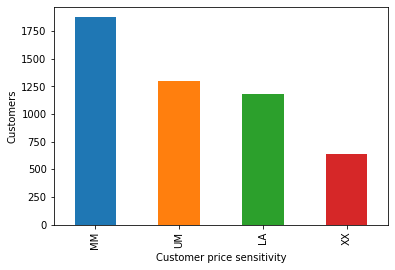

In [251]:
filtered_data_cust.CUST_PRICE_SENSITIVITY.value_counts().plot(kind='bar')
plt.ylabel('Customers')
plt.xlabel('Customer price sensitivity')
plt.show()

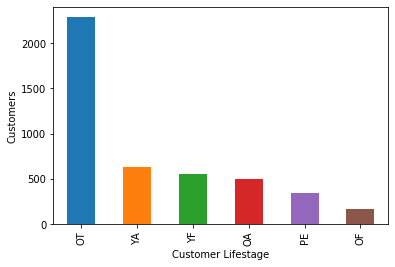

In [252]:
filtered_data_cust.CUST_LIFESTAGE.value_counts().plot(kind='bar')
plt.ylabel('Customers')
plt.xlabel('Customer Lifestage')
plt.show()

In [253]:
filtered_data_basket = df1[['BASKET_ID','BASKET_SIZE',
                            'BASKET_PRICE_SENSITIVITY','BASKET_TYPE',
                            'BASKET_DOMINANT_MISSION']].drop_duplicates()

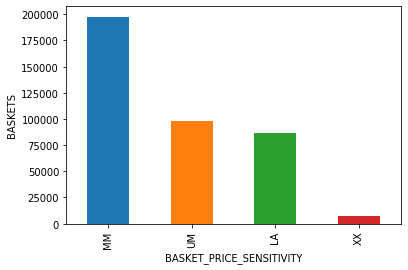

In [254]:
filtered_data_basket.BASKET_PRICE_SENSITIVITY.value_counts().plot(kind='bar')
plt.ylabel('BASKETS')
plt.xlabel('BASKET_PRICE_SENSITIVITY')
plt.show()

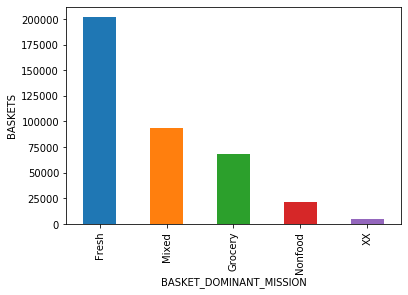

In [255]:
filtered_data_basket.BASKET_DOMINANT_MISSION.value_counts().plot(kind='bar')
plt.ylabel('BASKETS')
plt.xlabel('BASKET_DOMINANT_MISSION')
plt.show()

In [256]:
df1.describe().round(2).drop(['BASKET_ID', 'SHOP_WEEK'], axis = 'columns')

,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,Total_Spends
count,2541019.00,2541019.00,2541019.00,2541019.00,2541019.00
mean,3.99,14.83,1.49,1.90,4.02
std,2.00,3.66,1.55,2.86,57.11
min,1.00,8.00,1.00,0.00,0.00
25%,2.00,12.00,1.00,0.77,0.80
50%,4.00,15.00,1.00,1.23,1.28
75%,6.00,18.00,1.00,2.09,2.42
max,7.00,22.00,289.00,1283.94,80888.22


In [257]:
df2 = df1[['CUST_CODE', 'SHOP_DATE', 'QUANTITY', 'SPEND', 'BASKET_ID', 'Total_Spends']]

In [258]:
display(df2.SHOP_DATE.max()); display(df2.SHOP_DATE.min())

Timestamp('2008-07-06 00:00:00')

Timestamp('2006-04-10 00:00:00')

In [259]:
current = dt.datetime(2008,7,7)
df2.head()

,CUST_CODE,SHOP_DATE,QUANTITY,SPEND,BASKET_ID,Total_Spends
0,CUST0000410727,2007-05-29,1,1.56,994106000428564,1.56
1,CUST0000307323,2007-05-30,1,0.50,994106000362841,0.50
2,CUST0000410727,2007-05-29,3,1.23,994106000428564,3.69
3,CUST0000190750,2007-05-29,4,3.00,994106000288924,12.00
4,CUST0000410727,2007-05-29,3,2.82,994106000428564,8.46


#### **RFM Calculations**

In [333]:
# Calculating RFM

rfm_df = df2.groupby('CUST_CODE').agg({'SHOP_DATE': lambda date: (current - date.max()).days,
                                        'BASKET_ID': 'nunique',
                                        'Total_Spends': 'sum'})

In [334]:
rfm_df.head()

,SHOP_DATE,BASKET_ID,Total_Spends
CUST_CODE,,,
CUST0000000013,139,12,261.12
CUST0000000055,19,15,2671.55
CUST0000000679,73,14,141.73
CUST0000001052,23,31,316.90
CUST0000001058,45,2,137.50


In [367]:
# Renaming column names for convenience

rfm_df.rename(columns={'SHOP_DATE':'recency',
                         'BASKET_ID': 'frequency',
                         'Total_Spends': 'monetary value'}, inplace=True)

In [368]:
display(rfm_df.head())
display(rfm_df.shape)

,recency,frequency,monetary value,r_q,f_q,m_q,rfm_segment,rfm_score
CUST_CODE,,,,,,,,
CUST0000000013,139,12,261.12,1,2,2,122,5.0
CUST0000000055,19,15,2671.55,2,2,4,224,8.0
CUST0000000679,73,14,141.73,2,2,2,222,6.0
CUST0000001052,23,31,316.90,2,2,2,222,6.0
CUST0000001058,45,2,137.50,2,1,2,212,5.0


(5000, 8)

In [369]:
# Spliting data into quantiles

rec_label = range(4, 0,-1)
fre_label = range(1,5)
mon_label = range(1,5)

In [370]:
rfm_df['r_q'] = pd.qcut(rfm_df['recency'], 4, labels=rec_label)
rfm_df['f_q'] = pd.qcut(rfm_df['frequency'], 4, labels=fre_label)
rfm_df['m_q'] = pd.qcut(rfm_df['monetary value'], 4, labels=mon_label)

In [371]:
rfm_df.head()

,recency,frequency,monetary value,r_q,f_q,m_q,rfm_segment,rfm_score
CUST_CODE,,,,,,,,
CUST0000000013,139,12,261.12,1,2,2,122,5.0
CUST0000000055,19,15,2671.55,2,2,4,224,8.0
CUST0000000679,73,14,141.73,2,2,2,222,6.0
CUST0000001052,23,31,316.90,2,2,2,222,6.0
CUST0000001058,45,2,137.50,2,1,2,212,5.0


In [340]:
# Calculating rfm segemnts and rfm score

rfm_df['rfm_segment'] = rfm_df['r_q'].astype('str') + rfm_df['f_q'].astype('str') + rfm_df['m_q'].astype('str')
rfm_df['rfm_score'] = rfm_df['r_q'].astype('float') + rfm_df['f_q'].astype('float') + rfm_df['m_q'].astype('float')

In [341]:
display(rfm_df.head())
display(rfm_df.shape)

,recency,frequency,monetary value,r_q,f_q,m_q,rfm_segment,rfm_score
CUST_CODE,,,,,,,,
CUST0000000013,139,12,261.12,1,2,2,122,5.0
CUST0000000055,19,15,2671.55,2,2,4,224,8.0
CUST0000000679,73,14,141.73,2,2,2,222,6.0
CUST0000001052,23,31,316.90,2,2,2,222,6.0
CUST0000001058,45,2,137.50,2,1,2,212,5.0


(5000, 8)

In [342]:
# How does RFM segments look like

rfm_df.groupby('rfm_segment').size().sort_values(ascending = False)[:10]

rfm_segment
111    891
444    552
222    409
344    288
333    264
443    212
433    185
233    174
322    164
112    151
dtype: int64

In [343]:
rfm_df['rfm_score'].value_counts()

3.0     891
11.0    633
12.0    552
10.0    492
6.0     492
9.0     474
8.0     419
7.0     413
4.0     321
5.0     313
Name: rfm_score, dtype: int64

In [344]:
#Time Cohort analysis

def get_month(x):
    return dt.datetime(x.year, x.month, 1)

In [345]:
df4 = df2.copy()
df4['shop_month'] = df4['SHOP_DATE'].apply(get_month)

In [346]:
grouping = df4.groupby('CUST_CODE')['shop_month']
df4['CohortMonth'] = grouping.transform('min')

In [347]:
display(df4.head())
display(df4.shape)

,CUST_CODE,SHOP_DATE,QUANTITY,SPEND,BASKET_ID,Total_Spends,shop_month,CohortMonth
0,CUST0000410727,2007-05-29,1,1.56,994106000428564,1.56,2007-05-01,2006-04-01
1,CUST0000307323,2007-05-30,1,0.50,994106000362841,0.50,2007-05-01,2006-04-01
2,CUST0000410727,2007-05-29,3,1.23,994106000428564,3.69,2007-05-01,2006-04-01
3,CUST0000190750,2007-05-29,4,3.00,994106000288924,12.00,2007-05-01,2006-08-01
4,CUST0000410727,2007-05-29,3,2.82,994106000428564,8.46,2007-05-01,2006-04-01


(2541019, 8)

#### **Sequency/Consistency Analysis** (using standard deviation)

In [348]:
## Slicing data for Consistency analysis

df5 = df4[['CUST_CODE', 'SHOP_DATE']]

In [349]:
display(df5.head())
display(df5.shape)

,CUST_CODE,SHOP_DATE
0,CUST0000410727,2007-05-29
1,CUST0000307323,2007-05-30
2,CUST0000410727,2007-05-29
3,CUST0000190750,2007-05-29
4,CUST0000410727,2007-05-29


(2541019, 2)

In [350]:
# Dropping duplicates

df6 = df5.sort_values(by=['CUST_CODE', 'SHOP_DATE']).drop_duplicates()
df6.CUST_CODE.nunique()

5000

In [351]:
display(df6.head())
display(df6.CUST_CODE.nunique())

,CUST_CODE,SHOP_DATE
25981,CUST0000000013,2007-04-23
11826,CUST0000000013,2007-05-22
11057,CUST0000000013,2007-06-01
11389,CUST0000000013,2007-07-10
11222,CUST0000000013,2007-07-19


5000

In [352]:
# calulating diffrence from last visit made to the store

df6['diff'] = df6.sort_values(by=['CUST_CODE', 'SHOP_DATE']).groupby('CUST_CODE')['SHOP_DATE'].diff()

In [353]:
display(df6.head())
display(df6.shape)

,CUST_CODE,SHOP_DATE,diff
25981,CUST0000000013,2007-04-23,NaT
11826,CUST0000000013,2007-05-22,29 days
11057,CUST0000000013,2007-06-01,10 days
11389,CUST0000000013,2007-07-10,39 days
11222,CUST0000000013,2007-07-19,9 days


(347966, 3)

In [354]:
# dropping na

df7 = df6.dropna(subset=['diff'])
df7.head()

,CUST_CODE,SHOP_DATE,diff
11826,CUST0000000013,2007-05-22,29 days
11057,CUST0000000013,2007-06-01,10 days
11389,CUST0000000013,2007-07-10,39 days
11222,CUST0000000013,2007-07-19,9 days
24311,CUST0000000013,2007-10-08,81 days


In [355]:
#changing days to int data type

df7['diff'] = df7['diff'].dt.days.astype('int16')

/Users/adityakamboj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [313]:
df7.to_csv(r'/Users/adityakamboj/Desktop/Dunn/diff_export.csv')

**This is one area where I couldn't figure out the logic of how would I impute 2 time strore visitors, 1st visit as 0, as NaN values (1st visit) for those customers needs to be imputed for convenience of calculation.**

**So I simply downloaded this chunk and did the calculation in excel**

In [283]:
# calculating standard deviation by customer store visits (measurement of spread between visits)

df8 = df7.groupby('CUST_CODE')['diff'].agg('std').reset_index(name = 'std')
display(df8.head())

,CUST_CODE,std
0,CUST0000000013,27.631010
1,CUST0000000055,57.188189
2,CUST0000000679,59.435054
3,CUST0000001052,20.222441
4,CUST0000001058,NaN


In [364]:
#rfm_df.to_csv(r'/Users/adityakamboj/Desktop/Dunn/rfm_export.csv')

In [285]:
# splitting in quantiles

std_label = range(4, 0,-1)
df8['std_q'] = pd.qcut(df8['std'],4,labels=std_label)
df8.head()

,CUST_CODE,std,std_q
0,CUST0000000013,27.631010,2.0
1,CUST0000000055,57.188189,1.0
2,CUST0000000679,59.435054,1.0
3,CUST0000001052,20.222441,2.0
4,CUST0000001058,NaN,NaN


In [286]:
df8.to_csv(r'/Users/adityakamboj/Desktop/Dunn/std_export.csv')

#### **CLTV**

In [418]:
cltv = df2.groupby('CUST_CODE').agg({'SHOP_DATE': lambda date: (current - date.max()).days,
                                     'QUANTITY': 'sum',
                                        'BASKET_ID': 'nunique',
                                        'Total_Spends': 'sum'})

cltv.rename(columns={'SHOP_DATE':'days',
                         'QUANTITY': 'units',
                         'BASKET_ID': 'transactions',
                         'Total_Spends': 'spend'}, inplace=True)

cltv.head()

,days,units,transactions,spend
CUST_CODE,,,,
CUST0000000013,139,122,12,261.12
CUST0000000055,19,320,15,2671.55
CUST0000000679,73,78,14,141.73
CUST0000001052,23,98,31,316.90
CUST0000001058,45,46,2,137.50


In [419]:
# CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.

#average order value
cltv['Avg order values'] = cltv['spend']/cltv['transactions']
#purchase freqeuncy
purchase_frequency=sum(cltv['transactions'])/cltv.shape[0]
repeat_rate=cltv[cltv['transactions'] > 1].shape[0]/cltv.shape[0]
#Churn rate
churn_rate=1-repeat_rate
#profit margin
cltv['profit_margin']=cltv['spend']*0.05

cltv.head()

,days,units,transactions,spend,Avg order values,profit_margin
CUST_CODE,,,,,,
CUST0000000013,139,122,12,261.12,21.760000,13.0560
CUST0000000055,19,320,15,2671.55,178.103333,133.5775
CUST0000000679,73,78,14,141.73,10.123571,7.0865
CUST0000001052,23,98,31,316.90,10.222581,15.8450
CUST0000001058,45,46,2,137.50,68.750000,6.8750


In [621]:
#CLV was used in the analysis and not CLTV as to calcualte CLTV I made assumption of 5% profit margin, which did not seem to a good rationale

cltv['CLV']=(cltv['Avg order values']*purchase_frequency)/churn_rate
cltv['CLTV']=cltv['CLV']*cltv['profit_margin']

cltv['c_q'] = pd.qcut(cltv['CLV'], 4, labels=mon_label)

cltv.head()

,days,units,transactions,spend,Avg order values,profit_margin,CLV,CLTV,c_q
CUST_CODE,,,,,,,,,
CUST0000000013,139,122,12,261.12,21.760000,13.0560,13270.880000,1.732646e+05,3
CUST0000000055,19,320,15,2671.55,178.103333,133.5775,108620.770417,1.450929e+07,4
CUST0000000679,73,78,14,141.73,10.123571,7.0865,6174.113125,4.375285e+04,2
CUST0000001052,23,98,31,316.90,10.222581,15.8450,6234.496371,9.878559e+04,2
CUST0000001058,45,46,2,137.50,68.750000,6.8750,41928.906250,2.882612e+05,4


In [622]:
cltv.to_csv(r'/Users/adityakamboj/Desktop/Dunn/cltv_export.csv')

#### **Methodology - rfmc** joining rfm + c (consistency/sequency)

In [361]:
#Merging the datasets
rfmc = pd.merge(rfm_df,df8, on = 'CUST_CODE').drop(['r_q','f_q','m_q','std', 'rfm_score'], axis=1)
display(rfmc.head())
display(rfmc.shape)

,CUST_CODE,recency,frequency,monetary value,rfm_segment,std_q
0,CUST0000000013,139,12,261.12,122,2.0
1,CUST0000000055,19,15,2671.55,224,1.0
2,CUST0000000679,73,14,141.73,222,1.0
3,CUST0000001052,23,31,316.90,222,2.0
4,CUST0000001058,45,2,137.50,212,NaN


(4356, 6)

In [362]:
rfmc = rfmc.dropna(subset=['std_q'])
rfmc['rfmc'] = rfmc['rfm_segment'].astype('str') + rfmc['std_q'].astype('str')
rfmc = rfmc.drop(['std_q','rfm_segment'], axis = 1)
rfmc.head()

,CUST_CODE,recency,frequency,monetary value,rfmc
0,CUST0000000013,139,12,261.12,1222
1,CUST0000000055,19,15,2671.55,2241
2,CUST0000000679,73,14,141.73,2221
3,CUST0000001052,23,31,316.90,2222
5,CUST0000001098,19,41,751.69,2332


In [363]:
rfmc['rfmc'].value_counts()[:30]

4444    457
2221    252
3444    210
4434    139
2222    134
3333    131
4333    100
3332     98
4343     96
3343     95
3221     86
4443     84
2211     83
3222     74
2332     74
3443     73
2333     72
1111     71
2232     70
3434     67
2231     65
4332     64
4433     63
2111     58
3322     56
1221     56
3433     52
2343     50
1121     43
2322     40
Name: rfmc, dtype: int64

In [294]:
rfmc.to_csv(r'/Users/adityakamboj/Desktop/Dunn/rfmc_export.csv')

In [295]:
df6['previous_visit'] = df6.groupby('CUST_CODE')['SHOP_DATE'].shift()

In [298]:
averagespend.to_csv(r'/Users/adityakamboj/Desktop/Dunn/averagespend_export.csv')

In [314]:
df6.to_csv(r'/Users/adityakamboj/Desktop/Dunn/df6_export.csv')

In [297]:
# Calculating RFM

averagespend = df2.groupby('CUST_CODE').agg({'SHOP_DATE': lambda date: (current - date.max()).days,
                                        'BASKET_ID': 'nunique',
                                        'Total_Spends': 'mean'})

In [366]:
#new_cons = pd.read_csv('Correct_Std.csv')
df6.head()

,CUST_CODE,SHOP_DATE,diff
25981,CUST0000000013,2007-04-23,NaT
11826,CUST0000000013,2007-05-22,29 days
11057,CUST0000000013,2007-06-01,10 days
11389,CUST0000000013,2007-07-10,39 days
11222,CUST0000000013,2007-07-19,9 days


In [317]:
#new_cons.head()

,Row Labels,StdDev of diff
0,CUST0000000013,27.631010
1,CUST0000000055,57.188189
2,CUST0000000679,59.435054
3,CUST0000001052,20.222441
4,CUST0000001058,46.669048


In [318]:
#new_cons['c_q'] = pd.qcut(new_cons['StdDev of diff'], 4, std_label)

In [320]:
#display(new_cons.head())
#display(new_cons.shape)

,Row Labels,StdDev of diff,c_q
0,CUST0000000013,27.631010,2
1,CUST0000000055,57.188189,1
2,CUST0000000679,59.435054,1
3,CUST0000001052,20.222441,2
4,CUST0000001058,46.669048,1


(4356, 3)

In [321]:
#new_cons.to_csv(r'/Users/adityakamboj/Desktop/Dunn/new_cons.csv')

In [401]:
cust_data = df1.groupby(['CUST_CODE', 'CUST_PRICE_SENSITIVITY']).agg({'SHOP_DATE': lambda date: (current - date.max()).days,
                                        'BASKET_ID': 'nunique',
                                        'Total_Spends': 'sum'})

In [402]:
cust_data.shape

(5000, 3)

In [395]:
cust_data1 = df1.groupby(['CUST_CODE', 'CUST_LIFESTAGE']).agg({
                                        'Total_Spends': 'sum'})

In [397]:
cust_data1.shape

(4479, 1)

In [417]:
#cust_data.to_csv(r'/Users/adityakamboj/Desktop/Dunn/cust_data.csv')
#cust_data1.to_csv(r'/Users/adityakamboj/Desktop/Dunn/cust_data1.csv')

In [423]:
basket_data = df1.groupby(['CUST_CODE', 'CUST_PRICE_SENSITIVITY', 'BASKET_SIZE', 'BASKET_TYPE', 'BASKET_PRICE_SENSITIVITY'  ]).agg({'SHOP_DATE': lambda date: (current - date.max()).days,
                                        'BASKET_ID': 'nunique',
                                        'Total_Spends': 'sum',
                                        'QUANTITY': 'sum'})

In [427]:
display(basket_data.head())
display(basket_data.shape)

SHOP_DATE  \
CUST_CODE      CUST_PRICE_SENSITIVITY BASKET_SIZE BASKET_TYPE BASKET_PRICE_SENSITIVITY              
CUST0000000013 MM                     L           Full Shop   MM                              402   
                                                  Top Up      MM                              158   
                                      M           Small Shop  UM                              139   
                                      S           Small Shop  MM                              265   
CUST0000000055 LA                     L           Top Up      LA                               57   

                                                                                        BASKET_ID  \
CUST_CODE      CUST_PRICE_SENSITIVITY BASKET_SIZE BASKET_TYPE BASKET_PRICE_SENSITIVITY              
CUST0000000013 MM                     L           Full Shop   MM                                1   
                                                  Top Up      MM                                6   
                                      M           Small Shop  UM                                2   
                                      S           Small Shop  MM                                3   
CUST0000000055 LA                     L           Top Up      LA                                5   

                                                                                        Total_Spends  \
CUST_CODE      CUST_PRICE_SENSITIVITY BASKET_SIZE BASKET_TYPE BASKET_PRICE_SENSITIVITY                 
CUST0000000013 MM                     L           Full Shop   MM                               36.24   
                                                  Top Up      MM                              194.27   
                                      M           Small Shop  UM                               24.13   
                                      S           Small Shop  MM                                6.48   
CUST0000000055 LA                     L           Top Up      LA                             1461.44   

                                                                                        QUANTITY  
CUST_CODE      CUST_PRICE_SENSITIVITY BASKET_SIZE BASKET_TYPE BASKET_PRICE_SENSITIVITY            
CUST0000000013 MM                     L           Full Shop   MM                              26  
                                                  Top Up      MM                              79  
                                      M           Small Shop  UM                              12  
                                      S           Small Shop  MM                               5  
CUST0000000055 LA                     L           Top Up      LA                             159

(44129, 4)

In [428]:
basket_data = basket_data.reset_index()

In [429]:
basket_data.to_csv(r'/Users/adityakamboj/Desktop/Dunn/basket_data.csv')

## K-means

Following steps were taken:
1. skewness of the relevant variables was checked
2. Log transformation to make distribution better
3. Standardization was performed
4. Ran K-means
5. Original data and cluster data was joined to calculate summary stats for each cluster
6. Snake plot for viz

In [535]:
import seaborn as sns

In [536]:
rfmc_km = pd.read_csv('rfmc_km.csv')
rfmc_km = rfmc_km[['recency', 'frequency', 'monetary value', 'Con']]
rfmc_km.columns

Index(['recency', 'frequency', 'monetary value', 'Con'], dtype='object')

/Users/adityakamboj/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


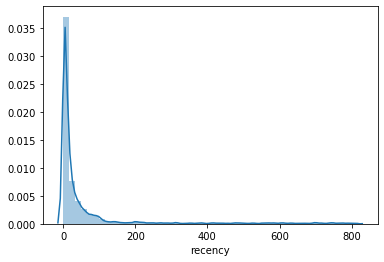

In [537]:
sns.distplot(rfmc_km['recency'])
plt.show()

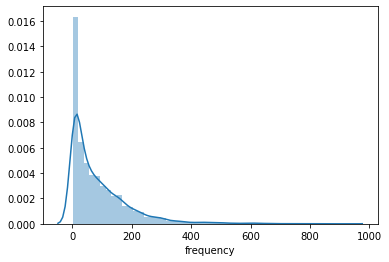

In [538]:
sns.distplot(rfmc_km['frequency'])
plt.show()

In [539]:
import numpy as np

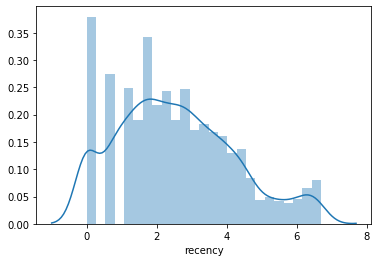

In [540]:
recency_log = np.log(rfmc_km['recency'])
sns.distplot(recency_log)
plt.show()

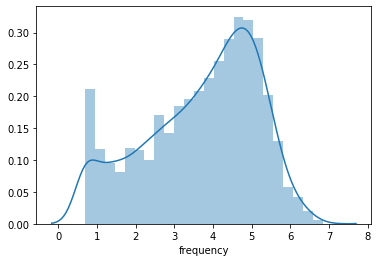

In [541]:
frequency_log = np.log(rfmc_km['frequency'])
sns.distplot(frequency_log)
plt.show()

In [542]:
rfmc_km.describe()

,recency,frequency,monetary value,Con
count,4356.000000,4356.000000,4356.000000,4356.000000
mean,58.158632,89.456382,2335.181786,39.617827
std,136.788097,104.182290,4846.671779,70.171355
min,1.000000,2.000000,0.030000,0.500000
25%,4.000000,15.000000,230.280000,5.231868
50%,11.000000,55.000000,987.450000,13.053707
75%,39.000000,128.250000,3060.360000,41.544285
max,814.000000,926.000000,205367.280000,570.635172


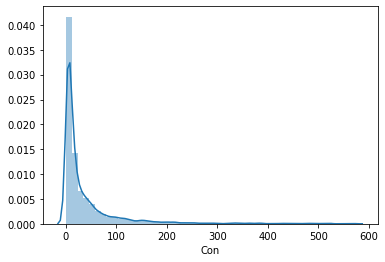

In [543]:
sns.distplot(rfmc_km['Con'])

#### without log

In [544]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(rfmc_km)
rfmc_km_normalized = scaler.transform(rfmc_km)

/Users/adityakamboj/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/adityakamboj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [545]:
print(rfmc_km_normalized.mean(axis=0),round(0))
print(rfmc_km_normalized.std(axis=0),round(2))

[-6.52472668e-18  2.12053617e-17 -2.03897709e-17 -1.65157144e-17] 0
[1. 1. 1. 1.] 2


In [549]:
rfmc_km_log = np.log(rfmc_km)

In [551]:
rfmc_km_log.head()
rfmc_km_log.reset_index()
rfmc_km_log.shape
rfmc_km_log.head()

,recency,frequency,monetary value,Con
0,4.934474,2.484907,5.564980,3.318939
1,2.944439,2.708050,7.890414,4.046347
2,4.290459,2.639057,4.953924,4.084884
3,3.135494,3.433987,5.758586,3.006793
4,3.806662,0.693147,4.923624,3.843081


#### With Log trans

In [552]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(rfmc_km_log)
rfmc_km_normalized_log = scaler.transform(rfmc_km_log)

In [553]:
print(rfmc_km_normalized_log.mean(axis=0),round(0))
print(rfmc_km_normalized_log.std(axis=0),round(2))

[-6.36160852e-17 -8.15590835e-18 -2.12053617e-16  2.93612701e-17] 0
[1. 1. 1. 1.] 2


In [565]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 3, random_state = 1)

In [566]:
kmeans.fit(rfmc_km_normalized_log)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

In [567]:
cluster_labels = kmeans.labels_

In [568]:
rfmc_km_k2 = rfmc_km.assign(Cluster = cluster_labels)

In [569]:
#rfmc_km_log = rfmc_km_log.dropna()
#np.isfinite(rfmc_km_log.all())
#rfmc_km_log = rfmc_km_log.replace([np.inf, -np.inf], np.nan)
#rfmc_km_log.shape
#rfmc_km_log[np.isnan(rfmc_km_log['Con'])]
#rfmc_km_log = rfmc_km_log.dropna()

In [570]:
rfmc_km_k2.groupby('Cluster').agg({'recency':'mean', 
                                  'frequency':'mean',
                                  'Con':'mean',
                                  'monetary value': ['mean','count']})

recency   frequency         Con monetary value      
               mean        mean        mean           mean count
Cluster                                                         
0         23.960376   38.603761   38.915357     899.723338  1489
1          5.486031  171.934634    6.284950    4584.283637  1897
2        213.664948    6.217526  105.884265     140.183247   970

In [572]:
rfmc_km_normalized_log = pd.DataFrame(rfmc_km_normalized_log, index = rfmc_km.index,
                                     columns = rfmc_km.columns)

In [611]:
rfmc_km_normalized_log['cluster'] = rfmc_km_k2['Cluster']

rfmc_km_normalized_log.dtypes
#cust_data1.to_csv(r'/Users/adityakamboj/Desktop/Dunn/cust_data1.csv')

recency           float64
frequency         float64
monetary value    float64
Con               float64
cluster             int32
dtype: object

In [612]:
rfmc_melt = pd.melt(rfmc_km_normalized_log.reset_index(), 
                   id_vars = 'cluster',
                   value_vars = ['recency','frequency','monetary value', 'Con'],
                    var_name = 'Attribute',
                    value_name = 'Value')

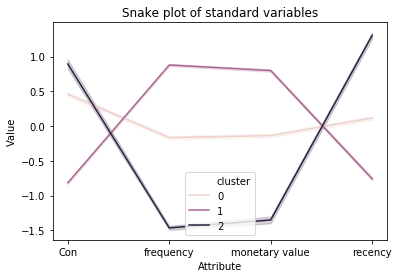

In [613]:
plt.title('Snake plot of standard variables')
sns.lineplot(x = 'Attribute', y = 'Value', hue='cluster', data = rfmc_melt)
plt.show()

In [614]:
rfmc_km_k2.groupby('Cluster').agg({'recency':'mean', 
                                  'frequency':'mean',
                                  'Con':'mean',
                                  'monetary value': ['mean','count']})

recency   frequency         Con monetary value      
               mean        mean        mean           mean count
Cluster                                                         
0         23.960376   38.603761   38.915357     899.723338  1489
1          5.486031  171.934634    6.284950    4584.283637  1897
2        213.664948    6.217526  105.884265     140.183247   970

In [616]:
rfmc_melt.to_csv(r'/Users/adityakamboj/Desktop/Dunn/rfmc_melt.csv')
rfmc_km_normalized_log.to_csv(r'/Users/adityakamboj/Desktop/Dunn/rfmc_km_normalized_log.csv')